In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import tabulate

ModuleNotFoundError: No module named 'tabulate'

In [3]:
import matplotlib as mpl

mpl.rc('figure',
       titlesize=24,
       figsize=(12,10),
      dpi=250,
      edgecolor='black',
    facecolor='white'
      )

mpl.rcParams['font.family'] = 'sans-serif' # 'sans-serif' , 'cursive' , 'fantasy','monospace' (e.g., Courier)

mpl.rc('lines',
       linewidth=2,
       color='r',
      linestyle='-',
      markersize=6,
      dash_joinstyle='miter', # miter/round/bevel
      dash_capstyle='butt',  #butt/round/projecting
      solid_joinstyle='miter',
      solid_capstyle='projecting',
      dashed_pattern= (2.8, 1.2),
       dashdot_pattern= (4.8, 1.2, 0.8, 1.2),
       dotted_pattern = (1.1, 1.1),
       scale_dashes = True
      )

mpl.rc('legend',
      fancybox=True, # if True, use a rounded box for the
      numpoints=1, # the number of marker points in the legend line
      markerscale =1,
      fontsize = 'medium',
      borderaxespad = 0.5) # the border between the axes and legend edge
             
mpl.rc('axes',
      facecolor='white',
      edgecolor='black',
      linewidth=1.9,
      grid=False,
      titlesize='large',
      labelsize='large',
      labelcolor='black',
      axisbelow='False') #draw axis gridlines and ticks below, patches (True); above patches but below, lines ('line'); or above all (False) 

mpl.rc('grid',
        color= 'gray',
       linestyle=':',
       linewidth=.8,
       alpha=1.)

mpl.rc('xtick',
      top=True, 
      bottom=True, 
      color ='k',
      labelsize = 'large',
      direction = 'in') 

mpl.rc('xtick.major',
      size=8.,
      width=2.,
      pad=3.5,
      top=True,
      bottom=True)

mpl.rc('xtick.minor',
      size=5.5,
      width=1.5,
      pad=3.4,
      top=True,
      bottom=True)

mpl.rc('ytick',
      right=False, 
      left=True, 
      color ='k',
      labelsize = 'large',
      direction = 'in') 

mpl.rc('ytick.major',
      size=8,
      width=2.,
      pad=3.5,
      left=True,
      right=True)

mpl.rc('ytick.minor',
      size=5.5,
      width=1.5,
      pad=3.4,
      left=True,
      right=True)


# Question 0 - Topics in Pandas

## Sparse Data Structures


`pandas` offers a way to speed up not only calculations in the typical `sparse` meaning, i.e. , `DataFrames` with 0's, but also for particular values or `NaN's`.


Let's first start showing the effect it has on discarding `NaN's` or a particular values and compare it with other methods. 

The goal of using `sparse` Data Structures is to allocate memory efficiently in large data sets and also speed-up possible operations between `sparse` Data Structures. `Sparse Data Structure` saved values and locations instead of the whole Dataframe. 


In [4]:
## Creating toy data.

array_nans = np.random.randn(500, 10000)

# Switching some values to NaN's to produce a sparse structure.
array_nans[10:499,1:9900] = np.nan

dense_df = pd.DataFrame(array_nans)
sparse_df = dense_df.astype(pd.SparseDtype("float", np.nan))

print(" Density of sparse DataFrame: "+str(sparse_df.sparse.density))

 Density of sparse DataFrame: 0.031877800000000005


## Efficiency in storing Sparse DataStructures

`Sparse DataStructures` are more efficient in allocating memory for large datasets with lots of NaN's or information that it is not of interest. The toy data has some sparsity $\sim$ 50%, but real data or matrices could have densities of the orden of $\sim$0.1 % or less.

In [5]:
## Let's compare the storing times for different methods and the same datastructure  being sparse or not.

print('Dense data structure : {:0.3f} bytes'.format(dense_df.memory_usage().sum() / 1e3))
print('Sparse data structure : {:0.3f} bytes'.format(sparse_df.memory_usage().sum() / 1e3))

Dense data structure : 40000.128 bytes
Sparse data structure : 1912.796 bytes


Even though the sparse allocate memory better, thy take slightly longer to be created. Nevertheless, we will prove that when there are heavy operations being undertaken in large sparse data structures, the speed-up is worth it, and the allocation of memory as well.

In [6]:
%timeit  df_2 = pd.DataFrame(array_nans)

112 µs ± 54.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%timeit  sparse_df = pd.DataFrame(array_nans).astype(pd.SparseDtype("float", np.nan))

3.18 s ± 219 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Speed-up of calculations in Sparse DataStructures and comparison with scipy.

Finally we compare the time it takes to operate on `Dense DataStructures` and `Sparse DataStructures`. Operating directly on `Sparse DataStructures` is not really efficient because `pandas` converts them to `Dense DataStructures` first. Nevertheless the `scipy` package has methods that take advantage of the psarsity of matrices to speed-up those processes.

In [8]:
## scipy also offers methods for sparse arrays, although in the full with 0's meaning,
from scipy.sparse import csr_matrix

rnd_array = np.zeros((10000,500))
rnd_array[200:223,13:26] = np.random.randn(23,13)
sparse_rnd_array = csr_matrix(rnd_array)
sparse_matrix_df = csr_matrix(sparse_df)

In [9]:
%timeit sparse_matrix_df.dot(sparse_rnd_array)

10.8 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%timeit dense_df.dot(rnd_array)

127 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see `Sparse` methods are specially useful to manage data with repeated values or just values we are not interested in. It can also be used to operate on them using `scipy` and its methods for `sparse` arrays, which could be much faster that standard multiplications. It is important to notice that it is only faster when the sparsity is significant, usually less than 1%.

# Question 1 - NHANES Table 1

### part a) 

In [11]:
columns_demo = ["SEQN","RIDAGEYR","RIDRETH3","DMDEDUC2",
                "DMDMARTL","RIDSTATR","SDMVPSU","WTMEC2YR",
                "WTINT2YR","RIAGENDR"]

columns_demo_new = ["id", "age", "race", "education",
                    "marital_status", "exam_status", 
                   "pseudo-psu_masked_var", 
                   "2yr_exam_weight", "2yr_interview_weight", "gender"]

dtypes = [int, int, int, int, int, int, int, float, float, int]

rename_cols = dict(zip(columns_demo, columns_demo_new))
data_types = dict(zip(columns_demo_new, dtypes))

yr_11_12 = pd.read_sas('./DEMO_G.XPT')[columns_demo]
yr_11_12["period"] =  "2011-2012"
yr_13_14 = pd.read_sas('./DEMO_H.XPT')[columns_demo]
yr_13_14["period"] =  "2013-2014"
yr_15_16 = pd.read_sas('./DEMO_I.XPT')[columns_demo]
yr_15_16["period"] =  "2015-2016"
yr_17_18 = pd.read_sas('./DEMO_J.XPT')[columns_demo]
yr_17_18["period"] =  "2017-2018"

# Stack all the different dataframes into one.
demo_data = pd.concat([yr_11_12, yr_13_14,
                       yr_15_16, yr_17_18],
                      ignore_index=True)

#Change Column Names.
demo_data.rename(columns=rename_cols, inplace=True)
demo_data["gender"] = pd.Categorical(np.where(demo_data.gender > 1.0,"female","male"))
#Change data types.
#demo_data = demo_data.astype(data_types)

### part b)

In [4]:
columns_oral

Index(['SEQN', 'OHDDESTS', 'OHX01TC', 'OHX02TC', 'OHX03TC', 'OHX04TC',
       'OHX05TC', 'OHX06TC', 'OHX07TC', 'OHX08TC', 'OHX09TC', 'OHX10TC',
       'OHX11TC', 'OHX12TC', 'OHX13TC', 'OHX14TC', 'OHX15TC', 'OHX16TC',
       'OHX17TC', 'OHX18TC', 'OHX19TC', 'OHX20TC', 'OHX21TC', 'OHX22TC',
       'OHX23TC', 'OHX24TC', 'OHX25TC', 'OHX26TC', 'OHX27TC', 'OHX28TC',
       'OHX29TC', 'OHX30TC', 'OHX31TC', 'OHX32TC', 'OHX02CTC', 'OHX03CTC',
       'OHX04CTC', 'OHX05CTC', 'OHX06CTC', 'OHX07CTC', 'OHX08CTC', 'OHX09CTC',
       'OHX10CTC', 'OHX11CTC', 'OHX12CTC', 'OHX13CTC', 'OHX14CTC', 'OHX15CTC',
       'OHX18CTC', 'OHX19CTC', 'OHX20CTC', 'OHX21CTC', 'OHX22CTC', 'OHX23CTC',
       'OHX24CTC', 'OHX25CTC', 'OHX26CTC', 'OHX27CTC', 'OHX28CTC', 'OHX29CTC',
       'OHX30CTC', 'OHX31CTC'],
      dtype='object')

In [3]:
columns_oral = ["SEQN"]


#Creating mask forthe required columns
or_11_12 = pd.read_sas('./OHXDEN_G.XPT')
mask1 = or_11_12.columns.str.contains("TC")
mask2 = ((or_11_12.columns=="SEQN") | (or_11_12.columns=="OHDDESTS"))
mask3 = or_11_12.columns.str.contains("CTC")
mask = mask1 | mask2
columns_oral = or_11_12.columns[mask]

or_11_12[columns_oral]
or_11_12["period"] =  "2011-2012"
or_13_14 = pd.read_sas('./OHXDEN_H.XPT')[columns_oral]
or_13_14["period"] =  "2013-2014"
or_15_16 = pd.read_sas('./OHXDEN_I.XPT')[columns_oral]
or_15_16["period"] =  "2015-2016"
or_17_18 = pd.read_sas('./OHXDEN_J.XPT')[columns_oral]
or_17_18["period"] =  "2017-2018"


dtypes_oral = [int]*2+[int]*sum(mask3 & mask1)+[str]*sum(mask3)
columns_oral_new = ["id", "ohx_status"]
columns_oral_new += [str(i)+" tooth count" for i in range(sum(mask3 & mask1))]
columns_oral_new += ["coronal caries "+str(i)+" tooth" for i in range(sum(mask3))]
rename_cols_oral = dict(zip(columns_oral, columns_oral_new))
data_types_oral = dict(zip(columns_oral_new, dtypes_oral))

#Stacking the data
oral_data = pd.concat([or_11_12[columns_oral], or_13_14, 
                       or_15_16, or_17_18], ignore_index=True)

#Change column names.
oral_data.rename(columns=rename_cols_oral, inplace=True)
#Change datatypes.
#oral_data = oral_data.astype(data_types_oral)

In [13]:
df = pd.merge(demo_data[["id","gender","age","education", "exam_status"]],
         oral_data[["id","ohx_status"]], on="id")

df["under_20"] = df.age<20
df["under_20"] = df["under_20"].astype("category")

df["college"] = pd.Categorical(np.where(df.education > 3,
                                        "some college/college graduate","No college/<20"))

df["ohx"] = pd.Categorical(np.where((df["exam_status"]==2) & (df["ohx_status"]==1),
                                     "complete","partial/incomplete"))

### part c)

In [14]:
df_clean = df.drop(df[df['exam_status']!=2].index)

total = demo_data.shape[0]
remaining = df_clean.shape[0]

print("Number of remaining subjects = "+str(remaining))
print("Number of removed subjects = "+str(total-remaining))


Number of remaining subjects = 35909
Number of removed subjects = 3247


### part d)

In [15]:
def fmt_mean_sd(df, complete="yes",
                fmt="{0:.0f} cases, {1:.1f}%; {2:.1f} +- {3:.1f} years"):
    """
    Funtion takes a DataFrame as input and return a string with the mean
    and standard deviation of the array.
    
    Inputs:
    ------
    df = DataFrame to calculate the statistics on.
    condition = Whether the ohx status is complete or not.
    Use 'yes' string otherwise it assumes incomplete.
    fmt = format fo the output string
    
    Returns:
    ----
    string = string containing the mean and standard deviation of the input array
    """
    if complete=="yes":
        condition = df["ohx"] =="complete"
    else:
        condition = df["ohx"] =="partial/incomplete"
    array = df["age"][condition]
    n = len(array)
    mean = np.mean(array)
    std = np.std(array)
    string = fmt.format(n,100.*n/remaining, mean, std)
    return string


def fmt_p_value(df, fmt="p-value for different ohx status: {0:.1e}"):
    """
    Funtion takes an array as input and return a string with the mean
    and standard deviation of the array.
    
    Inputs:
    ------
    df = DataFrame to calculate the statistics on.
    fmt = format fo the output string
    
    Returns:
    ----
    string = string containing the p-value fo between complete and incomplete stats
    """
    from scipy.stats import ttest_ind_from_stats

    array1 = df["age"][df["ohx"] =="complete"]
    n1 = len(array1)
    std1 = array1.std()
    mean_1 = array1.mean()
    
    array2 = df["age"][df["ohx"] =="partial/incomplete"]
    n2 = len(array1)
    std2 = array2.std()
    mean_2 = array2.mean()
    
    test = ttest_ind_from_stats(mean_1, std1, n1,
                                   mean_2, std2, n2)

    string = fmt.format(test.pvalue)
    return string
    
    
#df.groupby("gender").apply(np.mean)

df1 = pd.DataFrame(df.groupby(["under_20","college","gender"]).apply(fmt_mean_sd, complete="yes"))
df2 = pd.DataFrame(df.groupby(["under_20","college","gender"]).apply(fmt_mean_sd, complete="no"))
#Performs a t-test between the differnet populations with different ohx status.
df3 = pd.DataFrame(df.groupby(["under_20","college","gender"]).apply(fmt_p_value))

df_f = pd.merge(df1,df2, on=["under_20","college","gender"])
df_f = pd.merge(df_f,df3, on=["under_20","college","gender"])

df_f.rename(columns={'0_x':'ohx_complete; Age','0_y':'ohx_partial/incomplete; Age',
                     0:'p-value'})


ohx_complete; Age  \
under_20 college                       gender                                          
False    No college/<20                female  4344 cases, 12.1%; 52.7 +- 17.8 years   
                                       male    4619 cases, 12.9%; 50.9 +- 17.9 years   
         some college/college graduate female  6109 cases, 17.0%; 47.3 +- 17.1 years   
                                       male    5297 cases, 14.8%; 48.8 +- 17.8 years   
True     No college/<20                female    6889 cases, 19.2%; 9.2 +- 5.4 years   
                                       male      7102 cases, 19.8%; 9.1 +- 5.4 years   

                                                       ohx_partial/incomplete; Age  \
under_20 college                       gender                                        
False    No college/<20                female  363 cases, 1.0%; 53.4 +- 17.1 years   
                                       male    298 cases, 0.8%; 51.7 +- 16.0 years   
         some college/college graduate female  376 cases, 1.0%; 47.0 +- 16.0 years   
                                       male    240 cases, 0.7%; 48.7 +- 17.3 years   
True     No college/<20                female    137 cases, 0.4%; 9.9 +- 5.6 years   
                                       male      135 cases, 0.4%; 9.9 +- 5.2 years   

                                                                                 p-value  
under_20 college                       gender                                             
False    No college/<20                female  p-value for different ohx status: 3.5e-02  
                                       male    p-value for different ohx status: 1.6e-02  
         some college/college graduate female  p-value for different ohx status: 3.4e-01  
                                       male    p-value for different ohx status: 7.6e-01  
True     No college/<20                female  p-value for different ohx status: 2.3e-13  
                                       male    p-value for different ohx status: 2.1e-19

# Question 2 - Monte Carlo Comparison 

### a) Level Calibration

In [16]:
from numpy.random import default_rng
from copy import copy
from scipy.stats import norm


rng = default_rng(seed=12)
p_s = rng.random(60)
p_s = np.sort(p_s[p_s<0.5])

number_ps = len(p_s)

n_values = np.logspace(2,5,number_ps)

grid_p, grid_n = np.meshgrid(p_s, n_values)
number_ns = number_ps

#margin of error
epsilon = 0.005

#confidence interval
CI = 0.90

for i in range(number_ps):
    for j in range(number_ns):
        p_ij = grid_p[j,i]
        n_ij = int(grid_n[j,i])
        Sample = default_rng().random(n_ij)
        

In [17]:
def compute_Bin(array,CI=0.95, method="NA"):
    """
    Calculates confidence interval for a population from a binomial experiment.
    Inputs:
    -------
        array: 1D numpy.array or 1D numpy.array like object.
        method: {"NA","CP","J","AC"}. Default is NA.
        CI: Confidence interval, default is 0.95
    Returns:
    --------
        Dictionary with [point estimate, lower, upper, CI level]
    """
    from scipy.stats import norm, binom, beta
    import warnings
    try:
        array = np.array(array,dtype=float)
    except:
        print("The function input is not a 1D array or 1D array-type")
        return
    output = {}
    p = sum(array)/array.size
    n = array.size
    x = np.sum(array)
    alpha = (1-CI)
    z = (1+CI)/2.
    if method=="NA":
        std = np.sqrt(p*(1-p)/n)
        lw = p + norm.ppf(q=alpha)*std
        up = p + norm.ppf(q=1-alpha)*std
        output["est"] = p
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI
        if (p*n>12) or ((1-p)*n>12):
           warnings.warn("The approximation may not be adequate.") 
    elif method=="CP":   #Clopper-Pearson Method
        lw = beta.ppf(alpha/2.,x,n-x+1)
        up = beta.ppf(1-alpha/2.,x+1,n-x)
        output["est"] = p
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI
    elif method=="J":   #Jeffrey's Method
        lw = beta.ppf(alpha/2,x+0.5,n-x+0.5)
        up = beta.ppf(1-alpha/2.,x+1,n-x+0.5)
        output["est"] = p
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI
    elif method=="AC":   #Agresti-Coull
        n_AC = n+z**2
        p_AC = (x+z**2/2.)/n_AC
        std = np.sqrt(p_AC*(1-p_AC)/n)
        lw = p_AC + norm.ppf(q=alpha)*std
        up = p_AC + norm.ppf(q=1-alpha)*std
        output["est"] = p_AC
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI 
    else:
        print("Method is not valid. Use NA, CP, J or AC.")
        return
    return output
    
    
def compute_Bin_conf_level(array,CI=0.95, method="NA",
                formt="{0:.1f}% [{1:.0f}% CI: ({2:.1f} , {3:.1f})%]"):
    """
    Calculates confidence interval level for a population from a binomial experiment.
    Inputs:
    ------
        array: 1D numpy.array or 1D numpy.array like object.
        method: {"NA","CP","J","AC"}. Default is NA.      
    Returns:
    -------
        Width of the Confidence interval
    """
    from scipy.stats import norm, binom, beta
    import warnings
    try:
        array = np.array(array,dtype=float)
    except:
        print("The function input is not a 1D array or 1D array-type")
        return
    output = {}
    p = sum(array)/array.size
    n = array.size
    x = np.sum(array)
    alpha = (1-CI)
    z = (1+CI)/2.
    if method=="NA":
        std = np.sqrt(p*(1-p)/n)
        lw = p + norm.ppf(q=alpha)*std
        up = p + norm.ppf(q=1-alpha)*std
        output["est"] = p
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI
        if (p*n>12) or ((1-p)*n>12):
           warnings.warn("The approximation may not be adequate.") 
    elif method=="CP":   #Clopper-Pearson Method
        lw = beta.ppf(alpha/2.,x,n-x+1)
        up = beta.ppf(1-alpha/2.,x+1,n-x)
        output["est"] = p
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI
    elif method=="J":   #Jeffrey's Method
        lw = beta.ppf(alpha/2,x+0.5,n-x+0.5)
        up = beta.ppf(1-alpha/2.,x+1,n-x+0.5)
        output["est"] = p
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI
    elif method=="AC":   #Agresti-Coull
        n_AC = n+z**2
        p_AC = (x+z**2/2.)/n_AC
        std = np.sqrt(p_AC*(1-p_AC)/n)
        lw = p_AC + norm.ppf(q=alpha)*std
        up = p_AC + norm.ppf(q=1-alpha)*std
        output["est"] = p_AC
        output["lwr"] = lw
        output["upr"] = up
        output["level"] = CI 
    else:
        print("Method is not valid. Use NA, CP, J or AC.")
        return
    string = formt.format(p, 100*CI, lw, up)
    if formt==None:
        return output
    else:
        return string

    

In [18]:
conf_levels_mc = np.zeros([number_ps, number_ns, 4])
n_bootstraps = 100
sample = default_rng().random(1000000)
array = np.zeros(1000000)

for i in range(number_ps):
    for j in range(number_ns):
        p_ij = grid_p[j,i]
        n_ij = int(grid_n[j,i])
        array[sample<=p_ij] = 0
        array[sample>p_ij] = 1
        for k in range(n_bootstraps):
            sample_bootstrap = np.random.choice(array, int(n_ij))
            dic_method1 = compute_Bin(sample_bootstrap,CI=0.90, method="NA")
            if dic_method1["lwr"]<p_ij<dic_method1["upr"]:
                conf_levels_mc[i,j,0] +=1
            
            dic_method2 = compute_Bin(sample_bootstrap,CI=0.90, method="CP")
            if dic_method2["lwr"]<p_ij<dic_method2["upr"]:
                conf_levels_mc[i,j,1] +=1
            
            dic_method3 = compute_Bin(sample_bootstrap,CI=0.90, method="J")
            if dic_method3["lwr"]<p_ij<dic_method3["upr"]:
                conf_levels_mc[i,j,2] +=1
            
            dic_method4 = compute_Bin(sample_bootstrap,CI=0.90, method="AC")
            if dic_method4["lwr"]<=p_ij<=dic_method4["upr"]:
                conf_levels_mc[i,j,3] +=1



/var/folders/g1/1k2d0wx92779h845qvksjb5r0000gs/T/ipykernel_14393/248865404.py:35: UserWarning: The approximation may not be adequate.
  warnings.warn("The approximation may not be adequate.")


Text(0, 0.5, 'p')

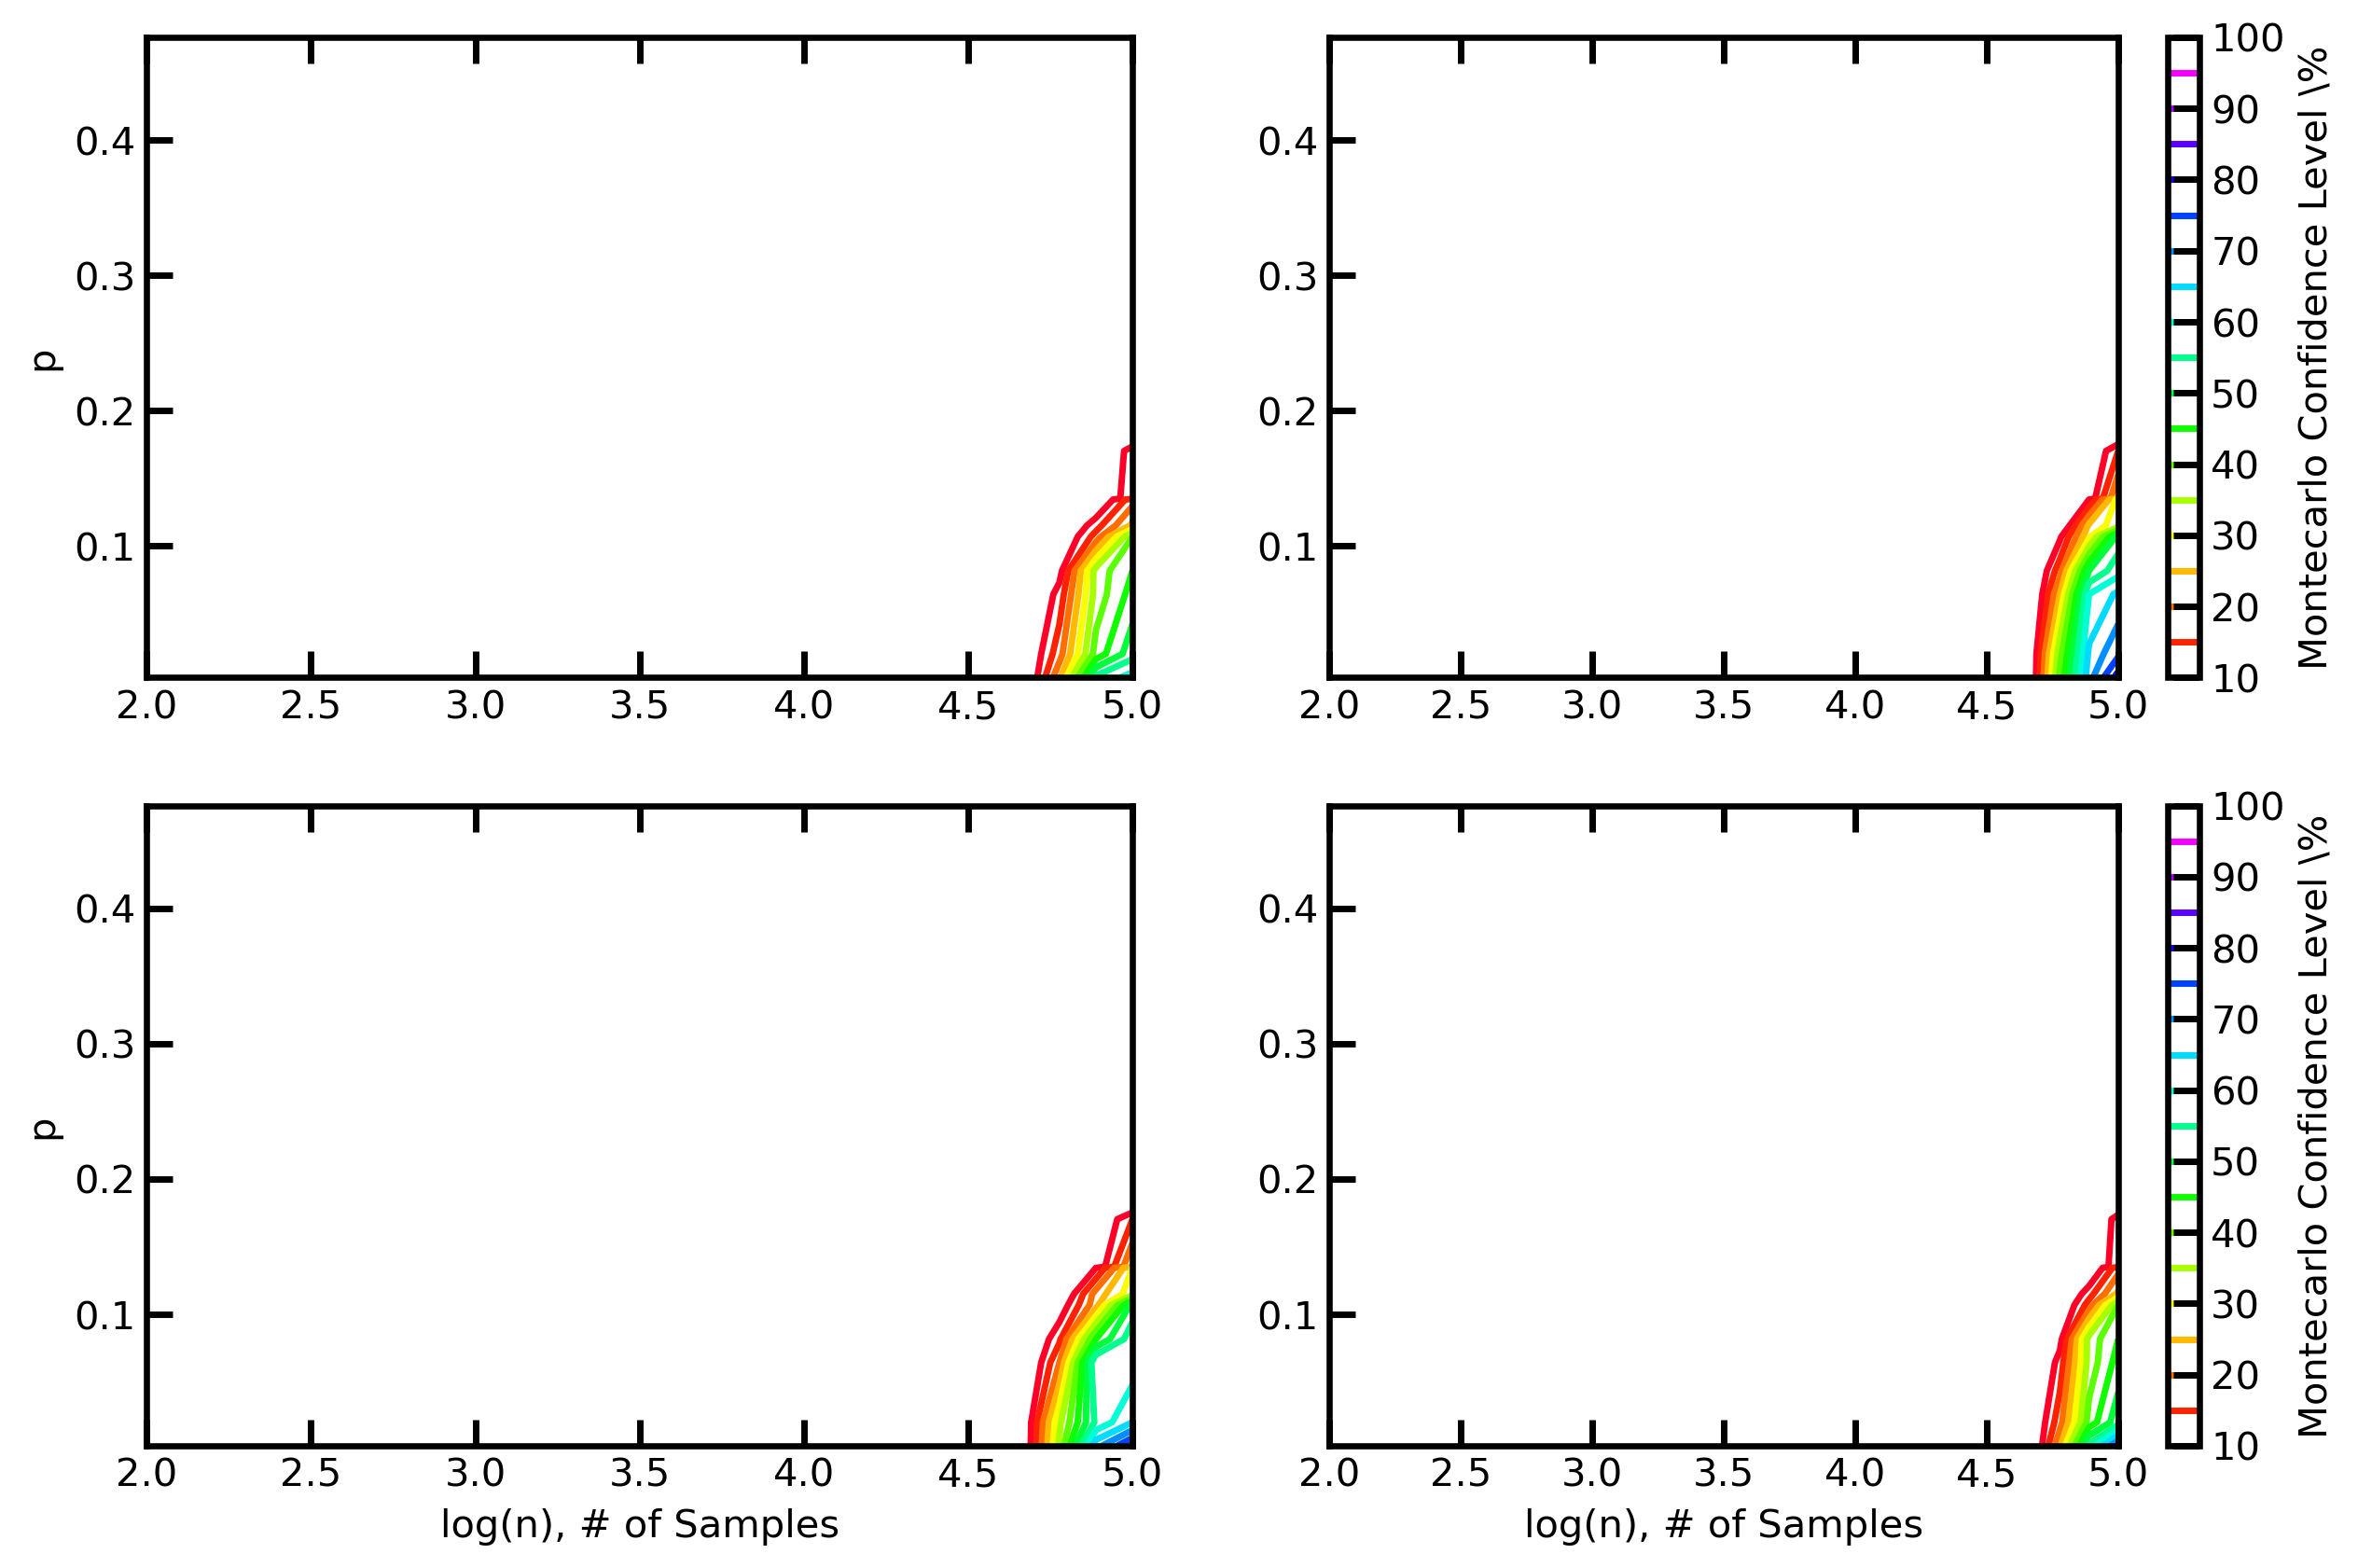

In [19]:

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

levels = np.linspace(10,100,19)

CS1 =axs[0,0].contour(np.log10(grid_n),grid_p,conf_levels_mc[:,:,0],
                      levels, cmap="gist_rainbow")
CS2 =axs[0,1].contour(np.log10(grid_n),grid_p,conf_levels_mc[:,:,1],
                      levels, cmap="gist_rainbow")

fig.colorbar(CS2, ax=axs[0,1], label="Montecarlo Confidence Level \%")


CS3 =axs[1,0].contour(np.log10(grid_n),grid_p,conf_levels_mc[:,:,2],
                      levels, cmap="gist_rainbow")
CS4 =axs[1,1].contour(np.log10(grid_n),grid_p,conf_levels_mc[:,:,3],
                      levels, cmap="gist_rainbow")

fig.colorbar(CS4, ax=axs[1,1], label="Montecarlo Confidence Level \%")

axs[1,0].set_xlabel("log(n), # of Samples")
axs[1,1].set_xlabel("log(n), # of Samples")

axs[0,0].set_ylabel("p")
axs[1,0].set_ylabel("p")


**Fig 1**: Contour plots of the confidence interval levels reached for different methods with a nominal 90% confidence intervals for a grid of $p$, binomial probability values and number of samples $n$. Top: Normal Approximation and Clopper-pearson interval. Bottom: Jeffrey's and Agresti-Coull intervals.

### b) Relative Efficiency

In [20]:
def compute_Bin_widths(array,CI=0.95, method="NA"):
    """
    Calculates confidence interval width for a population from a binomial experiment.
    Inputs:
    ------
        array: 1D numpy.array or 1D numpy.array like object.
        method: {"NA","CP","J","AC"}. Default is NA.
        CI: Confidence interval, default is 0.95
        
    Returns:
    -------
        Width of the Confidence interval
    """
    from scipy.stats import norm, binom, beta
    import warnings
    try:
        array = np.array(array,dtype=float)
    except:
        print("The function input is not a 1D array or 1D array-type")
        return
    output = {}
    p = sum(array)/array.size
    n = array.size
    x = np.sum(array)
    alpha = (1-CI)
    z = (1+CI)/2.
    if method=="NA":
        std = np.sqrt(p*(1-p)/n)
        lw = p + norm.ppf(q=alpha)*std
        up = p + norm.ppf(q=1-alpha)*std
        width = up - lw
        if (p*n>12) or ((1-p)*n>12):
           warnings.warn("The approximation may not be adequate.") 
    elif method=="CP":   #Clopper-Pearson Method
        lw = beta.ppf(alpha/2.,x,n-x+1)
        up = beta.ppf(1-alpha/2.,x+1,n-x)
    elif method=="J":   #Jeffrey's Method
        lw = beta.ppf(alpha/2,x+0.5,n-x+0.5)
        up = beta.ppf(1-alpha/2.,x+1,n-x+0.5)
    elif method=="AC":   #Agresti-Coull
        n_AC = n+z**2
        p_AC = (x+z**2/2.)/n_AC
        std = np.sqrt(p_AC*(1-p_AC)/n)
        lw = p_AC + norm.ppf(q=alpha)*std
        up = p_AC + norm.ppf(q=1-alpha)*std
    else:
        print("Method is not valid. Use NA, CP, J or AC.")
        return
    width = up - lw
    return width

In [28]:
methods = ["NA","CP","J","AC"]
CIs = [0.8,0.9,0.95]
widths_array = np.zeros([number_ps, number_ps, len(CIs), len(methods)])


for i in range(number_ps):
    for j in range(number_ns):
        for k in range(len(CIs)):
            p_ij = grid_p[j,i]
            n_ij = int(grid_n[j,i])
            array = default_rng().random(n_ij)
            array[array>p_ij] = 1
            array[array<=p_ij] = 0
            widths_array[j,i,k,0] = compute_Bin_widths(array,method="NA",CI=CIs[k])
            widths_array[j,i,k,1] = compute_Bin_widths(array,method="CP",CI=CIs[k])
            widths_array[j,i,k,2] = compute_Bin_widths(array,method="J",CI=CIs[k])
            widths_array[j,i,k,3] = compute_Bin_widths(array,method="AC",CI=CIs[k])

            

/var/folders/g1/1k2d0wx92779h845qvksjb5r0000gs/T/ipykernel_14393/1858053980.py:33: UserWarning: The approximation may not be adequate.
  warnings.warn("The approximation may not be adequate.")


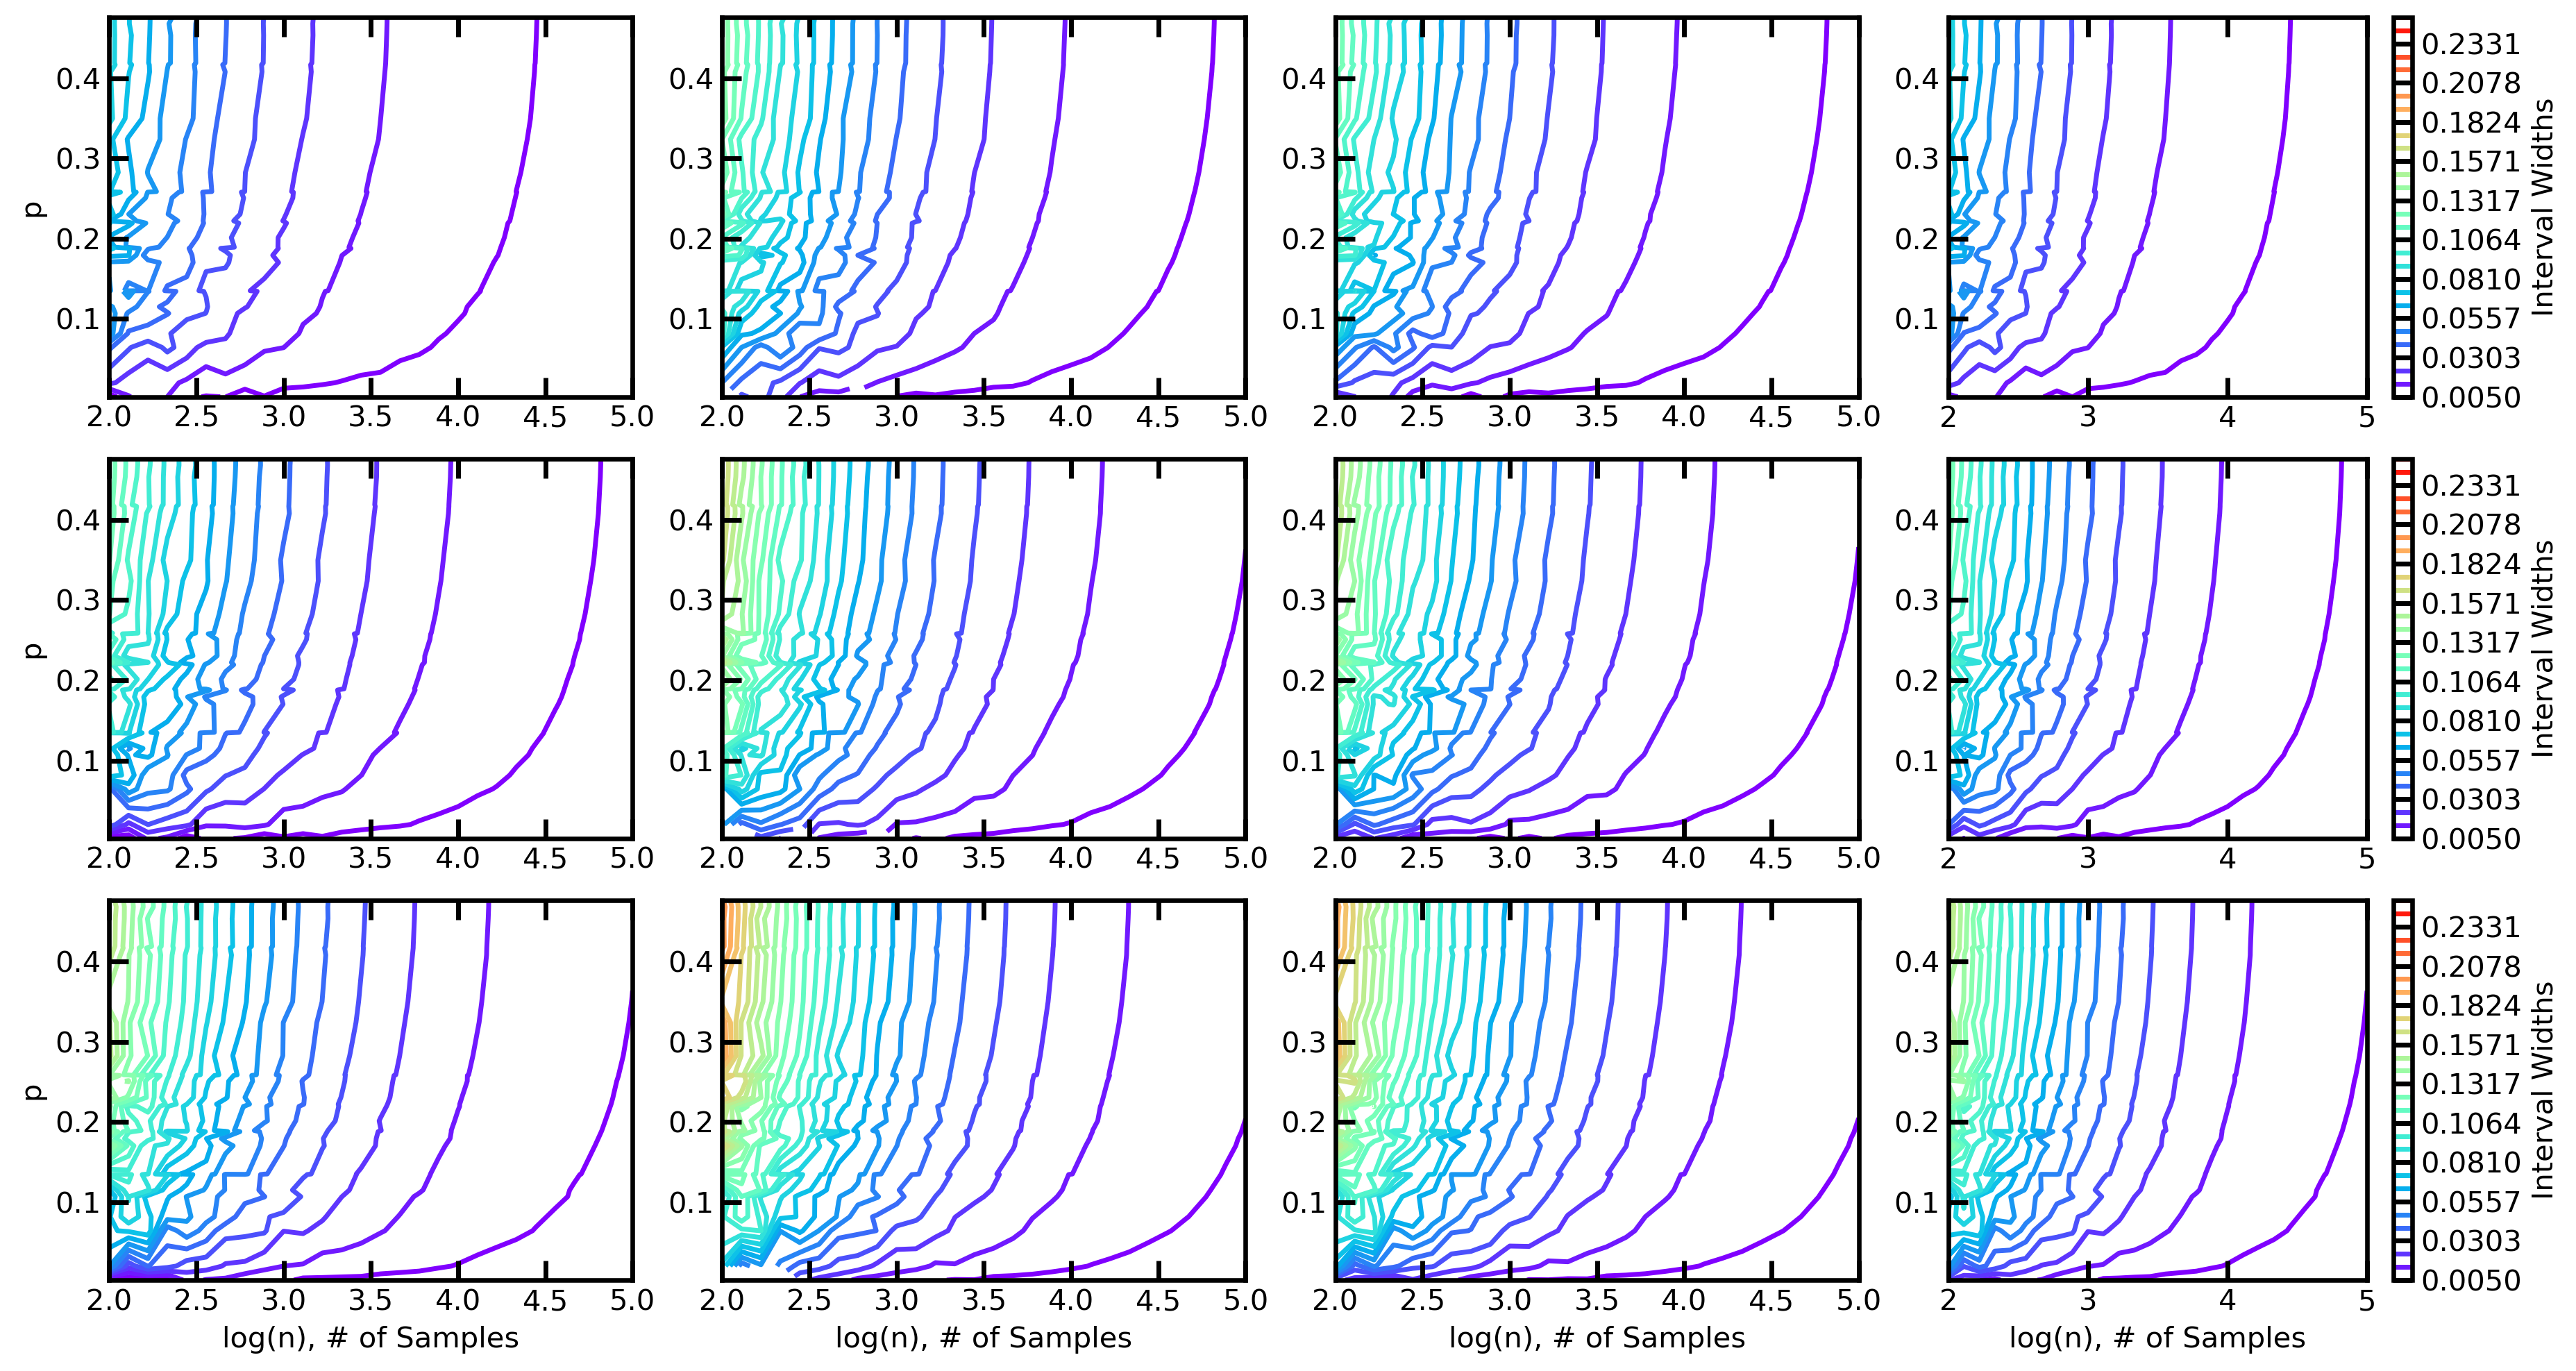

In [30]:

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15,8))

levels = np.linspace(0.005,0.25,30)
cmap = "rainbow"

CS1 =axs[0,0].contour(np.log10(grid_n),grid_p,widths_array[:,:,0,0],
                      levels, cmap=cmap)
CS2 =axs[0,1].contour(np.log10(grid_n),grid_p,widths_array[:,:,0,1],
                      levels, cmap=cmap)
CS3 =axs[0,2].contour(np.log10(grid_n),grid_p,widths_array[:,:,0,2],
                      levels, cmap=cmap)
CS4 =axs[0,3].contour(np.log10(grid_n),grid_p,widths_array[:,:,0,3],
                      levels, cmap=cmap)

fig.colorbar(CS4, ax=axs[0,3], label="Interval Widths")

CS5 =axs[1,0].contour(np.log10(grid_n),grid_p,widths_array[:,:,1,0],
                      levels, cmap=cmap)
CS6 =axs[1,1].contour(np.log10(grid_n),grid_p,widths_array[:,:,1,1],
                      levels, cmap=cmap)
CS7 =axs[1,2].contour(np.log10(grid_n),grid_p,widths_array[:,:,1,2],
                      levels, cmap=cmap)
CS8 =axs[1,3].contour(np.log10(grid_n),grid_p,widths_array[:,:,1,3],
                      levels, cmap=cmap)

fig.colorbar(CS8, ax=axs[1,3], label="Interval Widths")

CS9 =axs[2,0].contour(np.log10(grid_n),grid_p,widths_array[:,:,2,0],
                      levels, cmap=cmap)
CS10 =axs[2,1].contour(np.log10(grid_n),grid_p,widths_array[:,:,2,1],
                      levels, cmap=cmap)
CS11 = axs[2,2].contour(np.log10(grid_n),grid_p,widths_array[:,:,2,2],
                       levels, cmap=cmap)
CS12 = axs[2,3].contour(np.log10(grid_n),grid_p,widths_array[:,:,2,3],
                       levels, cmap=cmap)

fig.colorbar(CS12, ax=axs[2,3], label="Interval Widths")

axs[2,0].set_xlabel("log(n), # of Samples")
axs[2,1].set_xlabel("log(n), # of Samples")
axs[2,2].set_xlabel("log(n), # of Samples")
axs[2,3].set_xlabel("log(n), # of Samples")

axs[0,0].set_ylabel("p")
axs[1,0].set_ylabel("p")
axs[2,0].set_ylabel("p")

plt.tight_layout()

**Fig 2**: Contour plots of the confidence interval widths for different methods and confidence intervals for a grid of $p$, binomial probability values and number of samples $n$. From top to bottom, each row corresponds to a CI of 80%, 90%, and 95% respectively. From left to right the different methods: Normal Approximation, Clopper-Pearson interval, Jeffrey's interval and Agresti-Coull interval.

Text(0, 0.5, 'p')

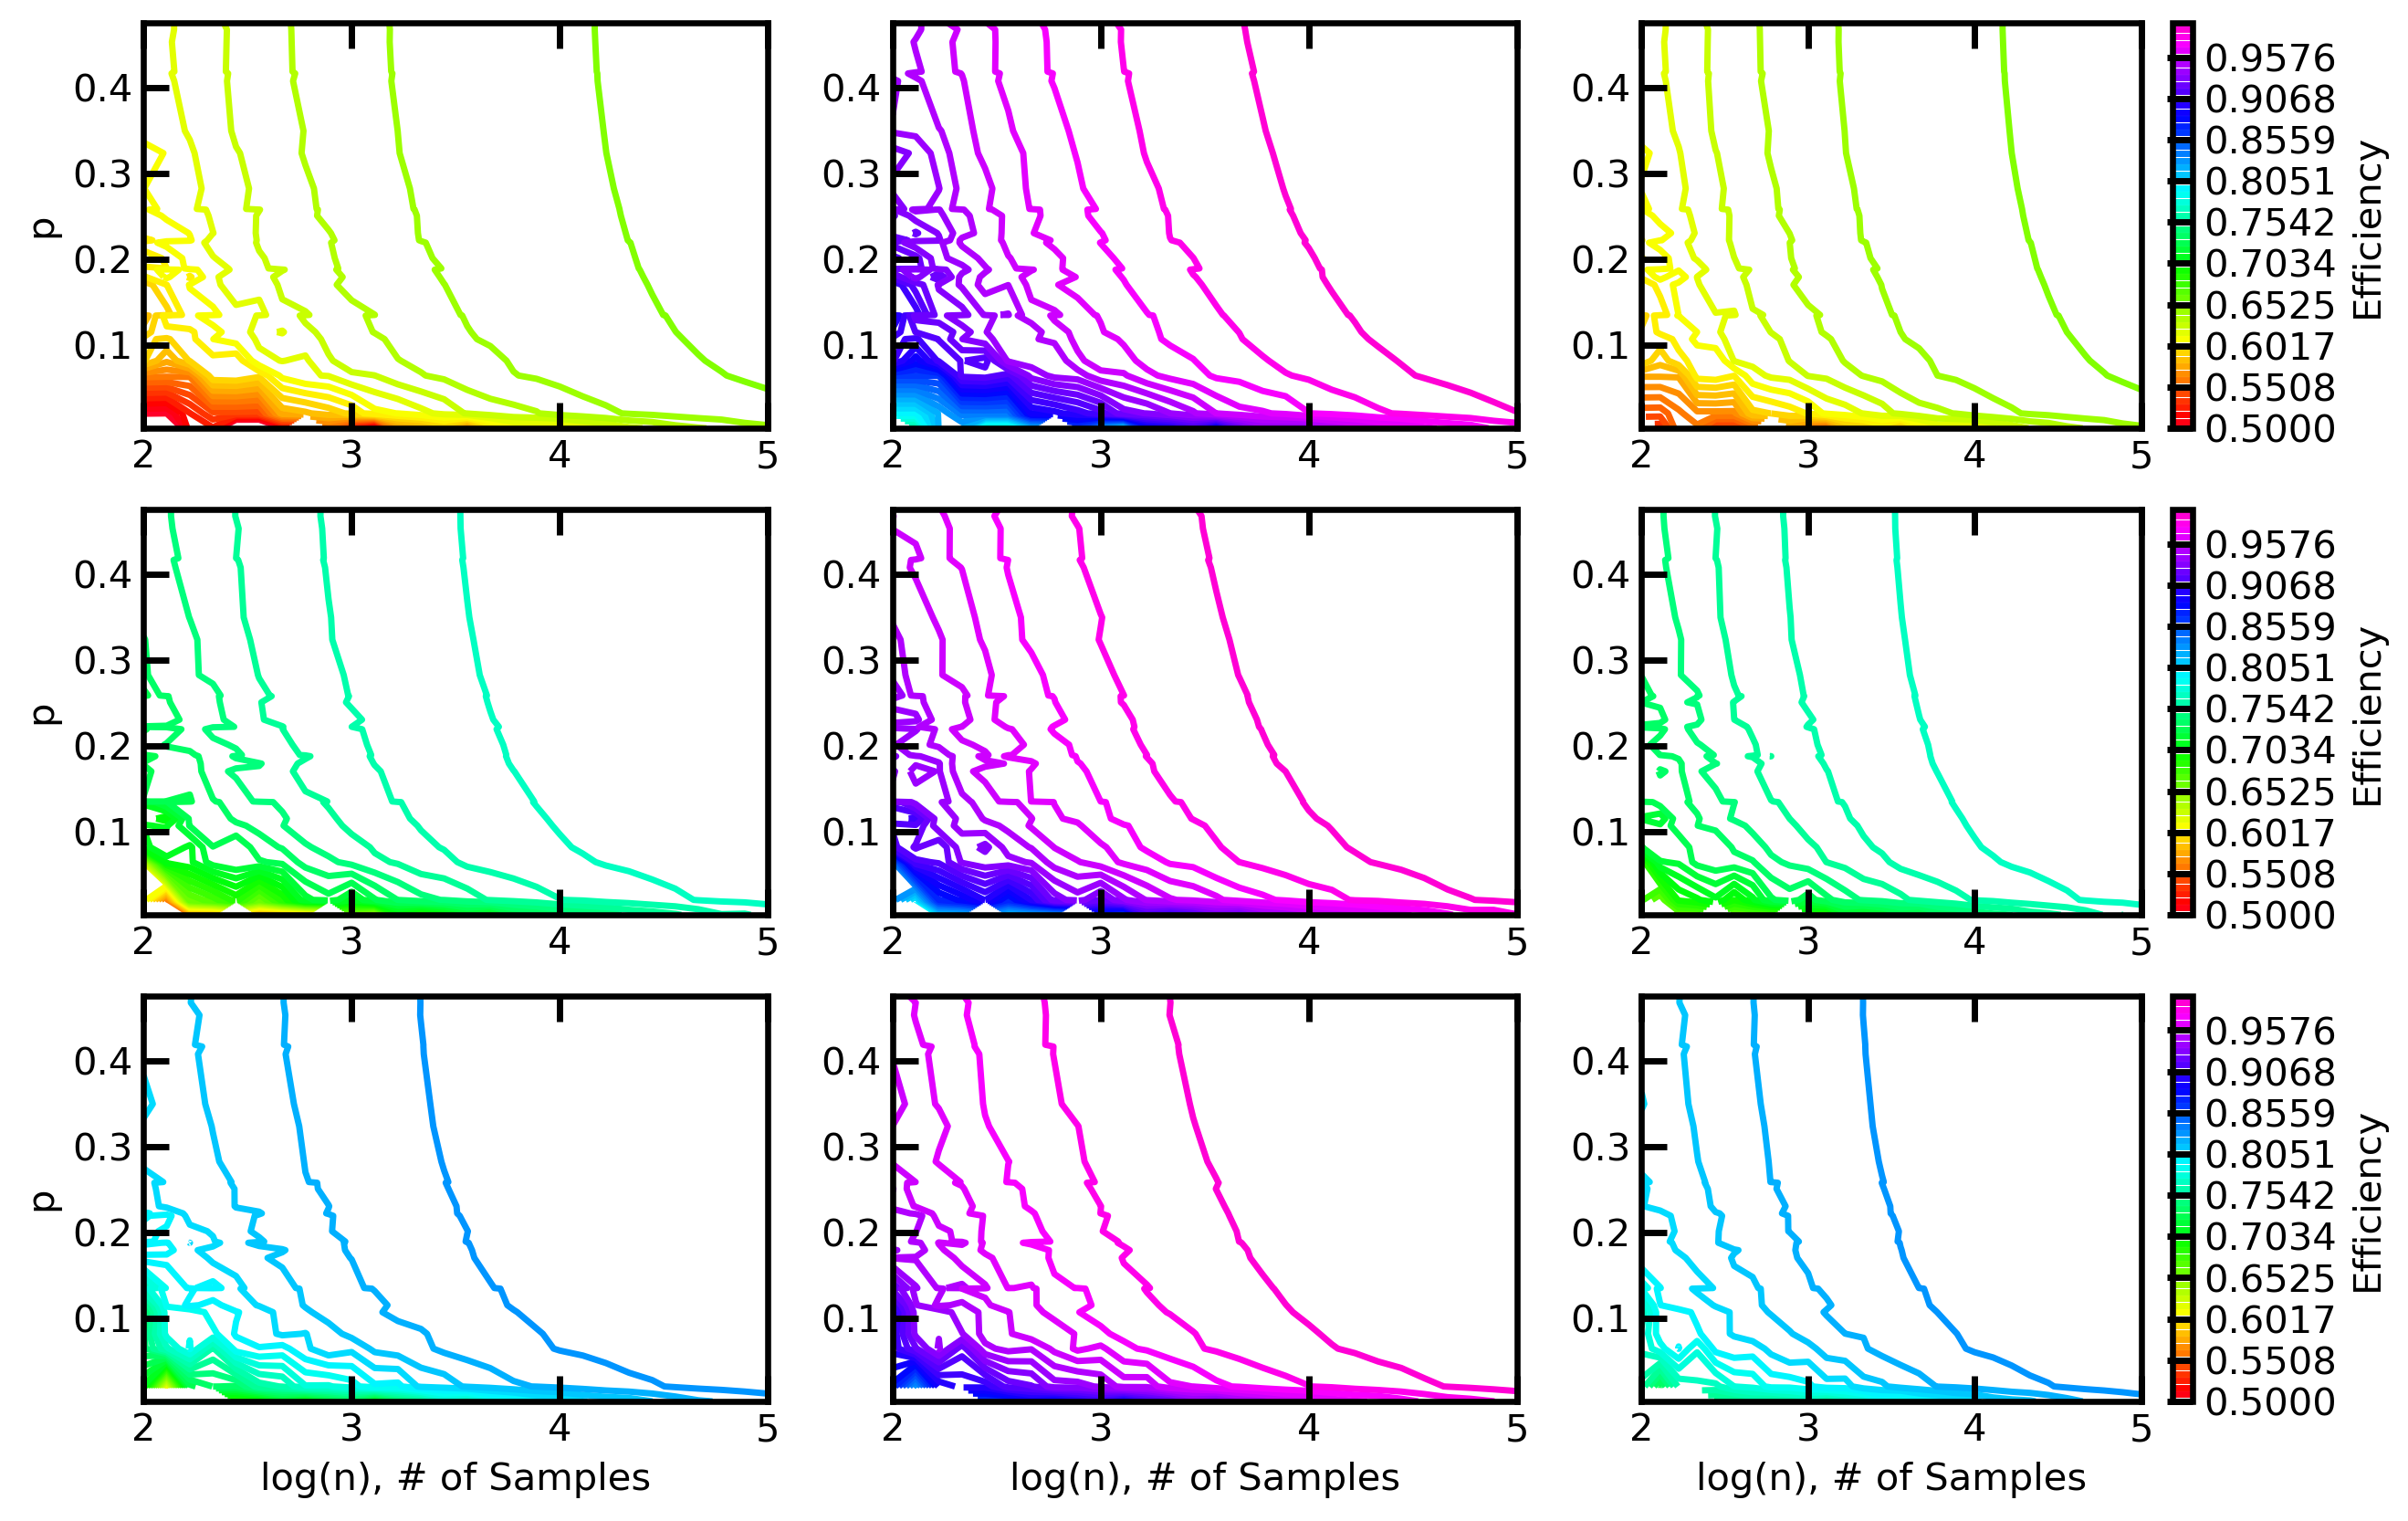

In [31]:

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,8))

levels = np.linspace(0.5,1.,60)

CS1 =axs[0,0].contour(np.log10(grid_n),grid_p,widths_array[:,:,0,0]/widths_array[:,:,0,1],
                      levels, cmap="gist_rainbow")
CS2 =axs[0,1].contour(np.log10(grid_n),grid_p,widths_array[:,:,0,2]/widths_array[:,:,0,1],
                      levels, cmap="gist_rainbow")
CS3 =axs[0,2].contour(np.log10(grid_n),grid_p,widths_array[:,:,0,3]/widths_array[:,:,0,1],
                      levels, cmap="gist_rainbow")

fig.colorbar(CS3, ax=axs[0,2], label="Efficiency")

CS4 =axs[1,0].contour(np.log10(grid_n),grid_p,widths_array[:,:,1,0]/widths_array[:,:,1,1],
                      levels, cmap="gist_rainbow")
CS5 =axs[1,1].contour(np.log10(grid_n),grid_p,widths_array[:,:,1,2]/widths_array[:,:,1,1],
                      levels, cmap="gist_rainbow")
CS6 =axs[1,2].contour(np.log10(grid_n),grid_p,widths_array[:,:,1,3]/widths_array[:,:,1,1],
                      levels, cmap="gist_rainbow")

fig.colorbar(CS6, ax=axs[1,2], label="Efficiency")

CS7 =axs[2,0].contour(np.log10(grid_n),grid_p,widths_array[:,:,2,0]/widths_array[:,:,2,1],
                      levels, cmap="gist_rainbow")
CS8 =axs[2,1].contour(np.log10(grid_n),grid_p,widths_array[:,:,2,2]/widths_array[:,:,2,1],
                      levels, cmap="gist_rainbow")
CS9 = axs[2,2].contour(np.log10(grid_n),grid_p,widths_array[:,:,2,3]/widths_array[:,:,2,1],
                       levels, cmap="gist_rainbow")

fig.colorbar(CS9, ax=axs[2,2], label="Efficiency")

axs[2,0].set_xlabel("log(n), # of Samples")
axs[2,1].set_xlabel("log(n), # of Samples")
axs[2,2].set_xlabel("log(n), # of Samples")

axs[0,0].set_ylabel("p")
axs[1,0].set_ylabel("p")
axs[2,0].set_ylabel("p")

**Fig 3**: Contour plots of the efficiency of confidence interval widths compared with the Clopper-Pearson method for a grid of $p$, binomial probability values, and number of samples $n$. From top to bottom, each row corresponds to a CI of 80%, 90%, and 95% respectively. From left to right the different methods: Normal Approximation, Jeffrey's interval and Agresti-Coull interval.